In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')
print(os.getcwd())

Mounted at /content/drive/
/content


In [ ]:
import pandas as pd
import numpy as np
# import HeidelTime
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
# from sentence_transformers import SentenceTransformer


import math
import typing as ty

from statistics import mean, harmonic_mean
from scipy.optimize import linear_sum_assignment

import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [ ]:

path = '/content/drive/MyDrive/Colab Notebooks/event_timeline_generation/letters_annotated.csv'

corpus = pd.read_csv(path)
corpus.head()

,book no./ year,Place,sentence,importance,tag,keywords,645,publication date,cluster
0,"volume43_book_393.txt (1930, May 4)",NaN,"LETTER TO VICEROY [May 4, 1930]1 DEAR FRIEND, ...",NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,to set out for Dharasana and reach there with ...,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,and demand possession of the Salt Works.,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,The public have been told that Dharasana is pr...,1.0,fact,"Dharasana Satyagraha, salt march, Dharasana",NaN,NaN,0.0
4,NaN,NaN,This is mere camouflage.,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
corpus = pd.read_csv('letters_annotated.csv')

# corpus = corpus.rename(columns={'Sentences Disassembled': 'sentence', 'Cluster': 'cluster'})
# corpus = corpus[['sentence', 'tag', 'cluster']]
corpus['tag'] = corpus['tag'].fillna('Other')
corpus = corpus[corpus['sentence'].notna()]
corpus.tag = corpus.tag.astype(str)
corpus.cluster = corpus.cluster.fillna(0)
corpus.cluster = corpus.cluster.astype(int)
corpus.tag = corpus.tag.replace({'fact': 'event'}) 
corpus['sentence'] = corpus['sentence'].astype(str)


corpus.head()

,book no./ year,Place,sentence,importance,tag,keywords,645,publication date,cluster
0,"volume43_book_393.txt (1930, May 4)",NaN,"LETTER TO VICEROY [May 4, 1930]1 DEAR FRIEND, ...",NaN,Other,NaN,NaN,NaN,0
1,NaN,NaN,to set out for Dharasana and reach there with ...,NaN,Other,NaN,NaN,NaN,0
2,NaN,NaN,and demand possession of the Salt Works.,NaN,Other,NaN,NaN,NaN,0
3,NaN,NaN,The public have been told that Dharasana is pr...,1.0,event,"Dharasana Satyagraha, salt march, Dharasana",NaN,NaN,0
4,NaN,NaN,This is mere camouflage.,NaN,Other,NaN,NaN,NaN,0


In [ ]:

test_path = '/content/drive/MyDrive/Colab Notebooks/event_timeline_generation/CWMG_action_tag.csv'
test_corpus = pd.read_csv(test_path)
test_corpus.head()


,Unnamed: 0,book no.,Place,sentence,importance,tag,keywords,645,publication date,cluster,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,action,index
0,3,volume43_book_393.txt,NaN,The public have been told that Dharasana is pr...,1.0,fact,"Dharasana Satyagraha, salt march, Dharasana",NaN,"1930, May 4",0.0,NaN,NaN,NaN,NaN,1.0,'tell',3
1,5,volume43_book_393.txt,NaN,It is as effectively under Government control ...,1.0,fact,"Dharasana, Lord Irwin",NaN,"1930, May 4",0.0,NaN,NaN,NaN,NaN,1.0,NaN,5
2,6,volume43_book_393.txt,NaN,Not a pinch of salt can be removed without the...,1.0,fact,"Lord Irwin, Dandi March, Dharasana",NaN,"1930, May 4",0.0,NaN,NaN,NaN,NaN,1.0,'remove',6
3,8,volume43_book_393.txt,NaN,He was arrested at 12.45 a.m. on May 5.,1.0,event,"arrest, salt satyagraha, imprisonment of Mahat...",NaN,"1930, May 4",1.0,NaN,NaN,NaN,NaN,1.0,'arrest',8
4,13,volume43_book_393.txt,NaN,"Instead, whilst the known leaders have been de...",1.0,event,"assault, nonviolent resistance, freedom struggle",NaN,"1930, May 4",2.0,NaN,NaN,NaN,NaN,1.0,'deal',13


In [ ]:
corpus['sentence'] = [entry.lower() for entry in corpus['sentence']]
corpus['sentence']= [word_tokenize(entry) for entry in corpus['sentence']]

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in enumerate(corpus['sentence']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    corpus.loc[index,'text_final'] = str(Final_words)

corpus.head()

,book no./ year,Place,sentence,importance,tag,keywords,645,publication date,cluster,text_final
0,"volume43_book_393.txt (1930, May 4)",NaN,"[letter, to, viceroy, [, may, 4, ,, 1930, ], 1...",NaN,Other,NaN,NaN,NaN,0.0,"['letter', 'viceroy', 'may', 'dear', 'friend',..."
1,NaN,NaN,"[to, set, out, for, dharasana, and, reach, the...",NaN,Other,NaN,NaN,NaN,0.0,"['set', 'dharasana', 'reach', 'companion']"
2,NaN,NaN,"[and, demand, possession, of, the, salt, works...",NaN,Other,NaN,NaN,NaN,0.0,"['demand', 'possession', 'salt', 'work']"
3,NaN,NaN,"[the, public, have, been, told, that, dharasan...",1.0,event,"Dharasana Satyagraha, salt march, Dharasana",NaN,NaN,0.0,"['public', 'tell', 'dharasana', 'private', 'pr..."
4,NaN,NaN,"[this, is, mere, camouflage, .]",NaN,Other,NaN,NaN,NaN,0.0,"['mere', 'camouflage']"


In [ ]:
corpus.tag.value_counts()

event     639
Other     308
demand     30
Name: tag, dtype: int64

In [ ]:
from sklearn.utils import resample


df_event = corpus[corpus.tag=='event']
df_other = corpus[corpus.tag=='Other']
df_fact = corpus[corpus.tag=='fact']
df_demand = corpus[corpus.tag=='demand']

# Upsample minority class
# df_fact = resample(df_fact, 
#                                  replace=True,     # sample with replacement
#                                  n_samples=150,    # to match majority class
#                                  random_state=123)
df_demand = resample(df_demand, 
                                 replace=True,     # sample with replacement
                                 n_samples=200,    # to match majority class
                                 random_state=123)

# df_other = resample(df_other, 
#                                  replace=True,     # sample with replacement
#                                  n_samples=150,    # to match majority class
#                                  random_state=123)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_event,  df_other, df_fact, df_demand])
 

# Display new class counts
df_upsampled.tag.value_counts()



event     639
Other     308
demand    200
Name: tag, dtype: int64

In [ ]:
corpus = df_upsampled
corpus = corpus[corpus['text_final'].notna()]

Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(corpus['text_final'],corpus['tag'],test_size=0.3 )

Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)
list(Encoder.classes_)

Tfidf_vect = TfidfVectorizer(max_features=10000)
Tfidf_vect.fit(corpus['text_final'].astype(str))
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)
print("SVM macro f1 Score -> ",f1_score(predictions_SVM, Test_Y, average='macro')*100)
print("SVM  micro f1 Score -> ",f1_score(predictions_SVM, Test_Y, average='micro')*100)
print("SVM weighted f1 Score -> ",f1_score(predictions_SVM, Test_Y, average='weighted')*100)

In [ ]:
test_corpus['sentence'] = [entry.lower() for entry in test_corpus['sentence']]
test_corpus['sentence']= [word_tokenize(entry) for entry in test_corpus['sentence']]

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in enumerate(test_corpus['sentence']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    test_corpus.loc[index,'text_final'] = str(Final_words)

test_corpus.head()


pred_X = test_corpus['text_final'].to_list()
pred_X_Tfidf = Tfidf_vect.transform(pred_X)

pred = SVM.predict(pred_X_Tfidf)
pred


In [ ]:
TN_list = []
for prediction, index in zip(pred, test_corpus['index'].to_list()):
    if prediction == 0:
        TN_list.append(index)

event_data = test_corpus[~test_corpus['index'].isin(TN_list)]

len(event_data)

event_data['id'] = event_data.index
event_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Unnamed: 0,book no.,Place,sentence,importance,tag,keywords,645,publication date,cluster,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,action,index,text_final,id
0,3,volume43_book_393.txt,NaN,"[the, public, have, been, told, that, dharasan...",1.0,fact,"Dharasana Satyagraha, salt march, Dharasana",NaN,"1930, May 4",0.0,NaN,NaN,NaN,NaN,1.0,'tell',3,"['public', 'tell', 'dharasana', 'private', 'pr...",0
1,5,volume43_book_393.txt,NaN,"[it, is, as, effectively, under, government, c...",1.0,fact,"Dharasana, Lord Irwin",NaN,"1930, May 4",0.0,NaN,NaN,NaN,NaN,1.0,NaN,5,"['effectively', 'government', 'control', 'vice...",1
2,6,volume43_book_393.txt,NaN,"[not, a, pinch, of, salt, can, be, removed, wi...",1.0,fact,"Lord Irwin, Dandi March, Dharasana",NaN,"1930, May 4",0.0,NaN,NaN,NaN,NaN,1.0,'remove',6,"['pinch', 'salt', 'remove', 'without', 'previo...",2
3,8,volume43_book_393.txt,NaN,"[he, was, arrested, at, 12.45, a.m., on, may, ...",1.0,event,"arrest, salt satyagraha, imprisonment of Mahat...",NaN,"1930, May 4",1.0,NaN,NaN,NaN,NaN,1.0,'arrest',8,"['arrest', 'may']",3
4,13,volume43_book_393.txt,NaN,"[instead, ,, whilst, the, known, leaders, have...",1.0,event,"assault, nonviolent resistance, freedom struggle",NaN,"1930, May 4",2.0,NaN,NaN,NaN,NaN,1.0,'deal',13,"['instead', 'whilst', 'know', 'leader', 'deal'...",4


In [ ]:
# list(Encoder.classes_)
# #['Other', 'demand', 'event', 'fact']
len(pred)
test_corpus['index'].isin(TN_list)

0      False
1      False
2      False
3      False
4      False
       ...  
395    False
396    False
397     True
398    False
399    False
Name: index, Length: 400, dtype: bool

# Unsupervised


In [ ]:
!pip install sentence-transformers

     |████████████████████████████████| 78 kB 4.8 MB/s 
     |████████████████████████████████| 3.1 MB 17.2 MB/s 
     |████████████████████████████████| 3.3 MB 53.2 MB/s 
     |████████████████████████████████| 1.2 MB 48.4 MB/s 
     |████████████████████████████████| 59 kB 8.8 MB/s 
     |████████████████████████████████| 596 kB 48.1 MB/s 
     |████████████████████████████████| 895 kB 84.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=b2fda2fd0fbe9bb8b26d77cc657c464b481f7b7137e94c2a4192d773c3844b8d
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-max-tokens' )
X = sbert_model.encode(event_data.sentence.tolist())
# X_tag = sbert_model.encode(event_file.keywords.tolist())
# X_con = np.hstack((X, X_tag))

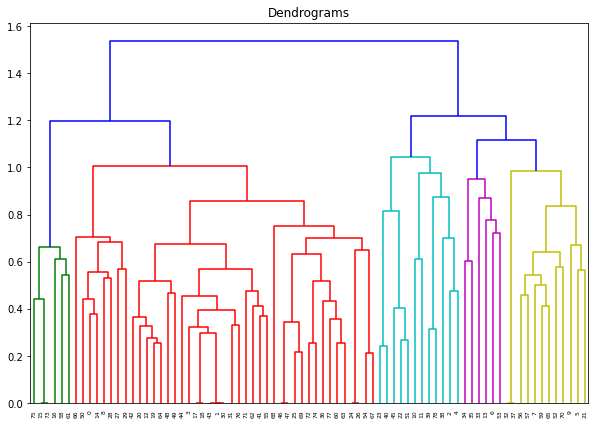

In [ ]:
from sklearn.preprocessing import normalize
data_scaled = normalize(X)
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms") 
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

In [ ]:
n_cluster = event_data.cluster.nunique()
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=n_cluster, affinity='euclidean', linkage='ward')  

labels=cluster.fit_predict(data_scaled)
title = event_data.sentence.tolist()
identifier = event_data.id.tolist()
wiki_cl=pd.DataFrame(list(zip(identifier, title,labels)),columns=['id','sentence','cluster'])
wiki_cl = wiki_cl.sort_values(by=['id'])
print(wiki_cl)

    id                                           sentence  cluster
0    0  [the, public, have, been, told, that, dharasan...       10
1    1  [it, is, as, effectively, under, government, c...        6
2    2  [not, a, pinch, of, salt, can, be, removed, wi...       20
3    3  [he, was, arrested, at, 12.45, a.m., on, may, ...        6
4    4  [instead, ,, whilst, the, known, leaders, have...       20
..  ..                                                ...      ...
74  84  [after, the, discussions, this, letter, was, g...        0
75  87  [the, wonderful, mass, response, to, the, move...       12
76  91  [they, can, not, persuade, themselves, to, see...        6
77  92  [we, feel, the, language, used, by, the, vicer...        0
78  93  [(, 2, ), if, the, foregoing, appears, to, be,...       21

[79 rows x 3 columns]


In [ ]:
cdict = {}
ldict = {}
key = []
response = []
labels = wiki_cl.cluster.tolist()
# identifier = event_file.id.tolist()
# identifier
for i, lab in zip(identifier, labels):
    try:
        cdict[lab].add(i)
    except:
        cdict[lab] = {i}
for k, v in cdict.items():
    response.append(v)

ground_truth_id = event_data.id.tolist()
ground_truth_lab = event_data.cluster.astype(int).tolist()

for i, lab in zip(ground_truth_id, ground_truth_lab):
    try:
        ldict[lab].add(i)
    except:
        ldict[lab] = {i}
#     key.append(set(x))
ldict

for k, v in ldict.items():
    key.append(v)

In [ ]:
print(muc(key, response))
print(b_cubed(key, response))
print(ceaf_e(key, response))
print(blanc(key, response))

(0.3076923076923077, 0.3076923076923077, 0.3076923076923077)
(0.41618444846292946, 0.4548986878100802, 0.43468126429992665)
(0.3871455704789038, 0.3871455704789038, 0.3871455704789038)
(0.5276796155062476, 0.528242297128964, 0.5279542035768009)


In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros
import keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.core import Flatten
from keras.layers import LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
# from keras.utils import to_categorical
from sklearn import preprocessing
from keras.utils.vis_utils import plot_model
from keras import initializers

import pandas as pd
import numpy as np
import re

In [ ]:


sentence_list = event_data.sentence.tolist()
cluster_list = event_data.cluster.tolist()
tag_list = event_data.keywords.tolist()
date_list = event_data['Date'].tolist()
action_list = event_data.action.tolist()
id_list = event_data.index.tolist()

pair_dict = {'id1': [], 'id2': [], 'sentence1': [], 'sentence2': [], 'date1': [], 'date2': [], 'action1': [], 'action2': [],'tag1': [], 'tag2': [],  'similarity': []}

for i in range(len(sentence_list)):
    for j in range(len(sentence_list)):
        pair_dict['id1'].append(id_list[i])
        pair_dict['id2'].append(id_list[j])
        pair_dict['sentence1'].append(sentence_list[i])
        pair_dict['sentence2'].append(sentence_list[j])
        pair_dict['tag1'].append(tag_list[i])
        pair_dict['tag2'].append(tag_list[j])
        pair_dict['action1'].append(action_list[i])
        pair_dict['action2'].append(action_list[j])
        pair_dict['date1'].append(date_list[i])
        pair_dict['date2'].append(date_list[j])
        if cluster_list[i] == cluster_list[j]:
            pair_dict['similarity'].append(1)
        else:
            pair_dict['similarity'].append(0)
df = pd.DataFrame.from_dict(pair_dict)


df.action1 = df.action1.fillna("")
df.action2 = df.action2.fillna("")
df.tag1 = df.tag1.fillna("")
df.tag2 = df.tag2.fillna("")
df.head()


,id1,id2,sentence1,sentence2,date1,date2,action1,action2,tag1,tag2,similarity
0,0,0,"[i, am, now, about, to, start, for, home, and,...","[i, am, now, about, to, start, for, home, and,...",Sept. 3. 1848,Sept. 3. 1848,'desire','desire',"'Pennsylvania politician', 'sagacious Pennsylv...","'Pennsylvania politician', 'sagacious Pennsylv...",1
1,0,1,"[i, am, now, about, to, start, for, home, and,...","[the, news, we, are, receiving, here, now, ,, ...",Sept. 3. 1848,Sept. 3. 1848,'desire',,"'Pennsylvania politician', 'sagacious Pennsylv...","'Springfield Illinois', 'LincolnThe news', 'Wh...",1
2,0,2,"[i, am, now, about, to, start, for, home, and,...","[lincoln, has, a, very, tall, and, thin, figur...",Sept. 3. 1848,"September 12, 1848",'desire',,"'Pennsylvania politician', 'sagacious Pennsylv...","'Gen Taylor', 'Mr Lincoln', 'Free Soil', 'Gene...",1
3,0,3,"[i, am, now, about, to, start, for, home, and,...","[he, spoke, in, a, clear, and, cool, ,, and, v...",Sept. 3. 1848,"September 12, 1848",'desire','speak',"'Pennsylvania politician', 'sagacious Pennsylv...","'Gen Taylor', 'Mr Lincoln', 'Free Soil', 'Gene...",1
4,0,4,"[i, am, now, about, to, start, for, home, and,...","[he, began, by, expressing, a, real, feeling, ...",Sept. 3. 1848,"September 12, 1848",'desire','begin',"'Pennsylvania politician', 'sagacious Pennsylv...","'Gen Taylor', 'Mr Lincoln', 'Free Soil', 'Gene...",1


In [ ]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(df[['id1', 'id2', 'sentence1', 'sentence2', 'action1', 'action2', 'date1', 'date2', 'tag1', 'tag2']], df.similarity, test_size=0.3, random_state=1000)
X_train, X_test, y_train, y_test = train_test_split(df[['id1', 'id2', 'sentence1', 'sentence2', 'action1', 'action2', 'date1', 'date2']], df.similarity, test_size=0.3, random_state=1000)


In [ ]:
from sklearn.preprocessing import MinMaxScaler


tokenizer = Tokenizer(num_words=5000)
# tokenizer.fit_on_texts(train_df.cleaned_text)
# X_train  = tokenizer.texts_to_sequences(train_df.cleaned_text)
# X_test  = tokenizer.texts_to_sequences(test_df.cleaned_text)
tokenizer.fit_on_texts(X_train.sentence1 + X_train.sentence2)
sentences_train = X_train
X_train1 = tokenizer.texts_to_sequences(X_train.sentence1)
X_train2 = tokenizer.texts_to_sequences(X_train.sentence2)
X_train3 = tokenizer.texts_to_sequences(X_train.date1)
X_train4 = tokenizer.texts_to_sequences(X_train.date2)
# X_train5 = tokenizer.texts_to_sequences(X_train.tag1)
# X_train6 = tokenizer.texts_to_sequences(X_train.tag2)
X_train7 = tokenizer.texts_to_sequences(X_train.action1)
X_train8 = tokenizer.texts_to_sequences(X_train.action2)

X_test1 = tokenizer.texts_to_sequences(X_test.sentence1)
X_test2 = tokenizer.texts_to_sequences(X_test.sentence2)
X_test3 = tokenizer.texts_to_sequences(X_test.date1)
X_test4 = tokenizer.texts_to_sequences(X_test.date2)
# X_test5 = tokenizer.texts_to_sequences(X_test.tag1)
# X_test6 = tokenizer.texts_to_sequences(X_test.tag2)
X_test7 = tokenizer.texts_to_sequences(X_test.action1)
X_test8 = tokenizer.texts_to_sequences(X_test.action2)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

maxlen_sent = 64
maxlen_other = 10
# X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_train1 = pad_sequences(X_train1, padding='post', maxlen=maxlen_sent)
X_train2 = pad_sequences(X_train2, padding='post', maxlen=maxlen_sent)
X_train3 = pad_sequences(X_train3, padding='post', maxlen=maxlen_other)
X_train4 = pad_sequences(X_train4, padding='post', maxlen=maxlen_other)
# X_train5 = pad_sequences(X_train5, padding='post', maxlen=maxlen_other)
# X_train6 = pad_sequences(X_train6, padding='post', maxlen=maxlen_other)
X_train7 = pad_sequences(X_train7, padding='post', maxlen=maxlen_other)
X_train8 = pad_sequences(X_train8, padding='post', maxlen=maxlen_other)

X_test1 = pad_sequences(X_test1, padding='post', maxlen=maxlen_sent)
X_test2 = pad_sequences(X_test2, padding='post', maxlen=maxlen_sent)
X_test3 = pad_sequences(X_test3, padding='post', maxlen=maxlen_other)
X_test4 = pad_sequences(X_test4, padding='post', maxlen=maxlen_other)
# X_test5 = pad_sequences(X_test5, padding='post', maxlen=maxlen_other)
# X_test6 = pad_sequences(X_test6, padding='post', maxlen=maxlen_other)
X_test7 = pad_sequences(X_test7, padding='post', maxlen=maxlen_other)
X_test8 = pad_sequences(X_test8, padding='post', maxlen=maxlen_other)



# prepare tokenizer
t = Tokenizer()
# docs = X_train.sentence1.astype(str) + X_train.sentence2.astype(str) + X_train.date1.astype(str) + X_train.date2.astype(str) + X_train.tag1.astype(str) + X_train.tag2.astype(str) + X_train.action1.astype(str) + X_train.action2.astype(str)
docs = X_train.sentence1.astype(str) + X_train.sentence2.astype(str) + X_train.date1.astype(str) + X_train.date2.astype(str) + X_train.action1.astype(str) + X_train.action2.astype(str)

# docs = X_train.sentence1

t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs)

# pad documents to a max length of 64 words
maxlen = 64
padded_docs = pad_sequences(encoded_docs, maxlen=maxlen, padding='post')
print(padded_docs)
# load the whole embedding into memory
embeddings_index = dict()
f = open('drive/MyDrive/Colab Notebooks/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[  11   14   53 ...    0    0    0]
 [  58 1321  105 ...   61   42 8129]
 [  93  537  551 ...    0    0    0]
 ...
 [ 113    5   10 ...  461   94 7892]
 [ 553    7  505 ...    0    0    0]
 [ 119    5   34 ...   61   42 2669]]
Loaded 400000 word vectors.


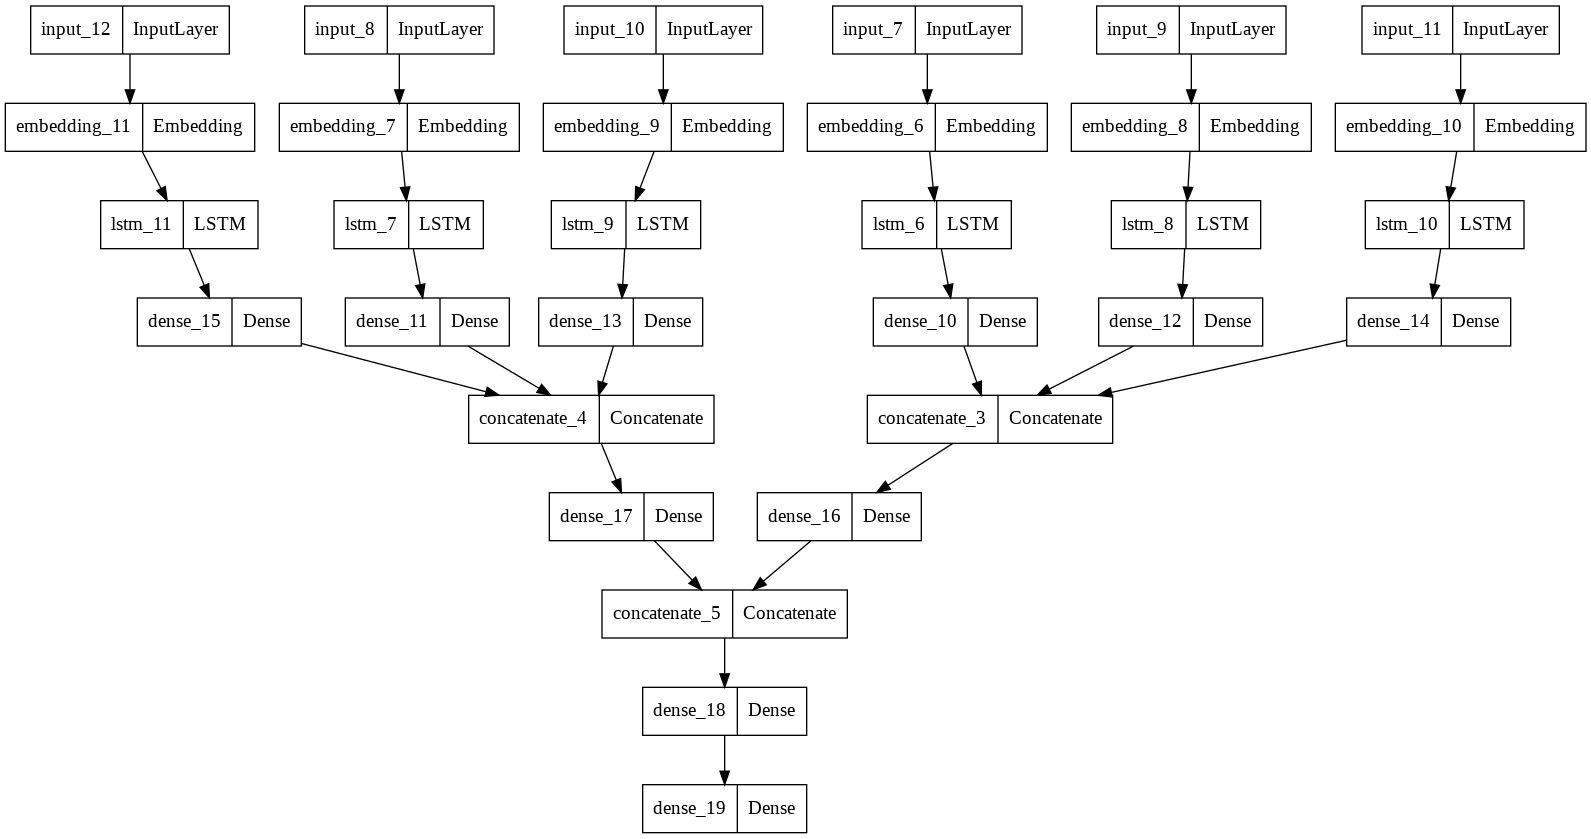

In [ ]:
input_1 = Input(shape=(64,))
input_2 = Input(shape=(64,))

input_3 = Input(shape=(maxlen_other,))
input_4 = Input(shape=(maxlen_other,))

# input_5 = Input(shape=(maxlen_other,))
# input_6 = Input(shape=(maxlen_other,))

input_7 = Input(shape=(maxlen_other,))
input_8 = Input(shape=(maxlen_other,))


embedding_layer1 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
embedding_layer2 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_2)
embedding_layer3 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_3)
embedding_layer4 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_4)
# embedding_layer5 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_5)
# embedding_layer6 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_6)
embedding_layer7 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_7)
embedding_layer8 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_8)

LSTM_Layer_1 = LSTM(128)(embedding_layer1)
LSTM_Layer_2 = LSTM(128)(embedding_layer2)
LSTM_Layer_3 = LSTM(128)(embedding_layer3)
LSTM_Layer_4 = LSTM(128)(embedding_layer4)
# LSTM_Layer_5 = LSTM(128)(embedding_layer5)
# LSTM_Layer_6 = LSTM(128)(embedding_layer6)
LSTM_Layer_7 = LSTM(128)(embedding_layer7)
LSTM_Layer_8 = LSTM(128)(embedding_layer8)


dense_layer_1 = Dense(64, activation='relu')(LSTM_Layer_1)
dense_layer_2 = Dense(64, activation='relu')(LSTM_Layer_2)
dense_layer_3 = Dense(32, activation='relu')(LSTM_Layer_3)
dense_layer_4 = Dense(32, activation='relu')(LSTM_Layer_4)
# dense_layer_5 = Dense(32, activation='relu')(LSTM_Layer_5)
# dense_layer_6 = Dense(32, activation='relu')(LSTM_Layer_6)
dense_layer_7 = Dense(32, activation='relu')(LSTM_Layer_7)
dense_layer_8 = Dense(32, activation='relu')(LSTM_Layer_8)

# concat_layer1 = Concatenate()([dense_layer_1, dense_layer_3, dense_layer_5, dense_layer_7])
concat_layer1 = Concatenate()([dense_layer_1, dense_layer_3, dense_layer_7])
dense_layer_5 = Dense(32, activation='relu')(concat_layer1)
# concat_layer2 = Concatenate()([dense_layer_2, dense_layer_4, dense_layer_6, dense_layer_8])
concat_layer2 = Concatenate()([dense_layer_2, dense_layer_4, dense_layer_8])
dense_layer_6 = Dense(32, activation='relu')(concat_layer2)

concat_layer = Concatenate()([dense_layer_5, dense_layer_6])

dense_layer_7 = Dense(64, activation='relu')(concat_layer)
# dense_layer_8 = Dropout(0.3)(dense_layer_7)
output = Dense(1, activation='sigmoid')(dense_layer_7)
model1 = Model(inputs=[input_1, input_2, input_3, input_4, input_7, input_8], outputs=output)
# model = Model(inputs=[input_1, input_2], outputs=output)

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

plot_model(model1, to_file='model_plot2.png',  show_layer_names=True)


In [ ]:

from sklearn.utils import compute_class_weight

w = compute_class_weight('balanced', np.unique(y_train), y_train)

# here I am adding only two categories with their corresponding weights
# you can spin a loop or continue by hand until you include all of your categories
weight = {
     np.unique(y_train)[0] : w[0], # class 0 with weight 0
     np.unique(y_train)[1] : w[1]  # class 1 with weight 1 
}

# # checkpoint = keras.callbacks.ModelCheckpoint('drive/MyDrive/Colab Notebooks/saved_models/model_covid_{epoch:08d}.h5', period=5) 
# history = model1.fit([X_train1, X_train2, X_train3, X_train4, X_train5, X_train6, X_train7, X_train8], y_train,
#                     epochs=20,
#                     verbose=True,
#                     batch_size=32,
#                     class_weight = weight)
                    # callbacks = [checkpoint] )

history = model1.fit([X_train1, X_train2, X_train3, X_train4, X_train7, X_train8], y_train,
                    epochs=20,
                    verbose=True,
                    batch_size=32,
                    class_weight = weight)


Epoch 1/20
2226/2226 [==============================] - 338s 148ms/step - loss: 0.6957 - acc: 0.3017
Epoch 2/20
2226/2226 [==============================] - 329s 148ms/step - loss: 0.6879 - acc: 0.2249
Epoch 3/20
2226/2226 [==============================] - 328s 147ms/step - loss: 0.6835 - acc: 0.1390
Epoch 4/20
2226/2226 [==============================] - 329s 148ms/step - loss: 0.6829 - acc: 0.0935
Epoch 5/20
2226/2226 [==============================] - 328s 147ms/step - loss: 0.6847 - acc: 0.1332
Epoch 6/20
2226/2226 [==============================] - 327s 147ms/step - loss: 0.6990 - acc: 0.2210
Epoch 7/20
2226/2226 [==============================] - 334s 150ms/step - loss: 0.6855 - acc: 0.2352
Epoch 8/20
2226/2226 [==============================] - 330s 148ms/step - loss: 0.6836 - acc: 0.1304
Epoch 9/20
2226/2226 [==============================] - 328s 148ms/step - loss: 0.6948 - acc: 0.1320
Epoch 10/20
2226/2226 [==============================] - 331s 149ms/step - loss: 0.6947 - a

In [ ]:
# model1 = keras.models.load_model('drive/MyDrive/Colab Notebooks/saved_models/model_covid_00000080.h5')
preds = model1.predict([X_test1, X_test2, X_test3, X_test4,  X_test7, X_test8])
preds = [1 if p > 0.5 else 0 for p in preds]

In [ ]:
max(X_test.id1)

399

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     29437
           1       0.00      0.00      0.00      1092

    accuracy                           0.96     30529
   macro avg       0.48      0.50      0.49     30529
weighted avg       0.93      0.96      0.95     30529



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# event_len = len(event_data.sentence.tolist())
event_len = max(X_test.id1) +1
data_res = np.zeros((event_len, event_len), dtype=int)
data_key = np.zeros((event_len, event_len), dtype=int)

cluster_mat_res = []
cluster_mat_key = []
num = 0
for i, j, sim in zip(X_test.id1, X_test.id2, preds):
    if sim == 1 and i !=j :
        cluster_mat_res.append([i, j])
        print(i,j)
        data_res[i][j] = 1
    # cluster_mat_res.append([i, j, sim])
    # data_res[i][j] = sim
for i, j, sim in zip(X_test.id1, X_test.id2, y_test):
    if i != j :
        cluster_mat_key.append([i, j])
        data_key[i][j] = sim




In [ ]:
from sklearn.cluster import SpectralClustering, AgglomerativeClustering

res_cluster = AgglomerativeClustering(affinity='precomputed', n_clusters=28, linkage='complete').fit(data_res)
key_cluster = AgglomerativeClustering(affinity='precomputed', n_clusters=28, linkage='complete').fit(data_key)

In [ ]:
key_identifier = list(range(0, len(key_cluster.labels_)))
res_identifier = list(range(0, len(res_cluster.labels_)))
key_labels = key_cluster.labels_
res_labels = res_cluster.labels_


cdict = {}
ldict = {}
key = []
response = []
# identifier = event_file.id.tolist()
# identifier
for i, lab in zip(res_identifier, res_labels):
    try:
        cdict[lab].add(i)
    except:
        cdict[lab] = {i}
for k, v in cdict.items():
    response.append(v)


for i, lab in zip(key_identifier, key_labels):
    try:
        ldict[lab].add(i)
    except:
        ldict[lab] = {i}
#     key.append(set(x))
ldict

for k, v in ldict.items():
    key.append(v)

In [ ]:
print(muc(key, response))
print(b_cubed(key, response))
print(ceaf_e(key, response))
print(blanc(key, response))

(0.967741935483871, 0.967741935483871, 0.9677419354838711)
(0.9439912788398854, 0.16479892761394102, 0.28060989269966874)
(0.5952396856257552, 0.5952396856257552, 0.5952396856257552)
(0.5471249980350648, 0.5349433695672973, 0.21391473155954374)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
# from sentence_transformers import SentenceTransformer
from sklearn.metrics import cohen_kappa_score

import math
import typing as ty

from statistics import mean, harmonic_mean

import numpy as np

from scipy.optimize import linear_sum_assignment

def trace(cluster: ty.Set, partition: ty.Iterable[ty.Set]) -> ty.Iterable[ty.Set]:
    remaining = set(cluster)
    for a in partition:
        common = remaining.intersection(a)
        if common:
            remaining.difference_update(common)
            yield common
    for x in sorted(remaining):
        yield set((x,))
        
class RemapClusteringsReturn(ty.NamedTuple):
    clusterings: ty.Sequence[ty.Sequence[ty.Sequence[int]]]
    elts_map: ty.Dict[ty.Hashable, int]


def remap_clusterings(
    clusterings: ty.Sequence[ty.Sequence[ty.Set[ty.Hashable]]],
) -> RemapClusteringsReturn:
    """Remap clusterings of arbitrary elements to clusterings of integers."""
    elts = set(e for clusters in clusterings for c in clusters for e in c)
    elts_map = {e: i for i, e in enumerate(elts)}
    res = []
    for clusters in clusterings:
        remapped_clusters = []
        for c in clusters:
            remapped_c = [elts_map[e] for e in c]
            remapped_clusters.append(remapped_c)
        res.append(remapped_clusters)
    return RemapClusteringsReturn(res, elts_map)

def muc(
    key: ty.Sequence[ty.Set], response: ty.Sequence[ty.Set]
) -> ty.Tuple[float, float, float]:

    # Edge case
    if all(len(k) == 1 for k in key) or all(len(r) == 1 for r in response):
        return 0.0, 0.0, 0.0
    R = sum(len(k) - sum(1 for _ in trace(k, response)) for k in key) / sum(
        len(k) - 1 for k in key
    )
    P = sum(len(r) - sum(1 for _ in trace(r, key)) for r in response) / sum(
        len(r) - 1 for r in response
    )
    F = harmonic_mean((R, P))
    return R, P, F

def b_cubed(
    key: ty.Sequence[ty.Set], response: ty.Sequence[ty.Set]
) -> ty.Tuple[float, float, float]:
    if sum(len(k) for k in key) == 0:
        R = 0.0
    else:
        R = math.fsum(
            len(k.intersection(r)) ** 2 / len(k) for k in key for r in response
        ) / sum(len(k) for k in key)
    if sum(len(r) for r in response) == 0:
        P = 0.0
    else:
        P = math.fsum(
            len(r.intersection(k)) ** 2 / len(r) for r in response for k in key
        ) / sum(len(r) for r in response)
    F = harmonic_mean((R, P))
    return R, P, F

def ceaf(
    key: ty.Sequence[ty.Set],
    response: ty.Sequence[ty.Set],
    score: ty.Callable[[ty.Set, ty.Set], float],
) -> ty.Tuple[float, float, float]:
    if len(response) == 0 or len(key) == 0:
        return 0.0, 0.0, 0.0
    else:
        cost_matrix = np.array([[-score(k, r) for r in response] for k in key])
        # TODO: See https://github.com/allenai/allennlp/issues/2946 for ideas on speeding
        # the next line up
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        total_score = -cost_matrix[row_ind, col_ind].sum()
        R = total_score / math.fsum(score(k, k) for k in key)
        P = total_score / math.fsum(score(r, r) for r in response)
        F = harmonic_mean((R, P))
        return R, P, F
def ceaf_e(
    key: ty.Sequence[ty.Set], response: ty.Sequence[ty.Set]
) -> ty.Tuple[float, float, float]:

    def Φ_4(k, r):
        return 2 * len(k.intersection(r)) / (len(k) + len(r))

    return ceaf(key, response, Φ_4)

def blanc(
    key: ty.Sequence[ty.Set], response: ty.Sequence[ty.Set], fast=True,
) -> ty.Tuple[float, float, float]:
    r"""
    Return the BLANC `$(R, P, F)$` scores for a `#response` clustering given a `#key` clustering.
    ## Notes
      - Mention identifiers have to be comparable
      - To ensure the compliance with the reference implementation, the edge cases results are
        those from Recasens and Hovy (2011) rather than from the more recent Luo et al. (2014) when
        those two disagree. This has an effect for the N-6 testcase, where according to Luo et al.
        (2014), BLANC should be `$\frac{0+F_n}{2}$` since `$C_k=∅$` and `$C_r≠∅$`, but according to
        Recasens and Hovy (2011), BLANC should be `$F_n$`.
    """
    if fast:
        C_score, N_score = fast_detailed_blanc(key, response)
    else:
        C_score, N_score = detailed_blanc(key, response)
    if C_score is None:
        assert N_score is not None  # nosec:B101
        return N_score
    if N_score is None:
        assert C_score is not None  # nosec:B101
        return C_score
    return ty.cast(
        ty.Tuple[float, float, float],
        tuple(np.mean((C_score, N_score), axis=0).tolist()),
    )


def links_from_clusters(
    clusters: ty.Iterable[ty.Set],
) -> ty.Tuple[
    ty.Set[ty.Tuple[ty.Hashable, ty.Hashable]],
    ty.Set[ty.Tuple[ty.Hashable, ty.Hashable]],
]:
    r"""
    Return a `(coreference_links, non-coreference_links)` tuple corresponding to a clustering.
    The links are given as sorted couples for uniqueness
    """
    clusters_lst = [list(c) for c in clusters]
    C = set()
    N = set()
    for i, c in enumerate(clusters_lst[:-1]):
        for j, e in enumerate(c[:-1]):
            # Since the links are symmetric, we only add the links between `e` and
            # the following mentions
            for f in c[j + 1 :]:
                C.add((e, f) if e <= f else (f, e))
        for other in clusters_lst[i + 1 :]:
            for e in c:
                for f in other:
                    N.add((e, f) if e <= f else (f, e))
    #  We missed the coreference links for the last cluster, add them here
    last_cluster = clusters_lst[-1]
    for j, e in enumerate(last_cluster):
        for f in last_cluster[j + 1 :]:
            C.add((e, f) if e <= f else (f, e))
    return C, N


def detailed_blanc(
    key: ty.Sequence[ty.Set], response: ty.Sequence[ty.Set]
) -> ty.Tuple[
    ty.Union[ty.Tuple[float, float, float], None],
    ty.Union[ty.Tuple[float, float, float], None],
]:
    """Return BLANC `$(R, P, F)$` scores for coreference and non-coreference respectively."""

    # Edge case : a single mention in both `key` and `response` clusters
    # in that case, `C_k`, `C_r`, `N_k` and `N_r` are all empty, so we need a separate examination
    # of the mentions to know if we are very good or very bad.
    if len(key) == len(response) == 1 and len(key[0]) == len(response[0]) == 1:
        if key[0] == response[0]:
            return ((1.0, 1.0, 1.0), (1.0, 1.0, 1.0))
        else:
            return ((0.0, 0.0, 0.0), (0.0, 0.0, 0.0))

    C_k, N_k = links_from_clusters(key)
    C_r, N_r = links_from_clusters(response)

    tp_c = len(C_k.intersection(C_r))
    tp_n = len(N_k.intersection(N_r))
    c_k, n_k = len(C_k), len(N_k)
    c_r, n_r = len(C_r), len(N_r)

    if not c_k and not c_r:
        R_c, P_c, F_c = (1.0, 1.0, 1.0)
    elif not c_k or not c_r:
        R_c, P_c, F_c = (0.0, 0.0, 0.0)
    else:
        R_c, P_c = tp_c / c_k, tp_c / c_r
        F_c = 2 * tp_c / (c_k + c_r)

    if not n_k and not n_r:
        R_n, P_n, F_n = (1.0, 1.0, 1.0)
    elif not n_k or not n_r:
        R_n, P_n, F_n = (0.0, 0.0, 0.0)
    else:
        R_n, P_n = tp_n / n_k, tp_n / n_r
        F_n = 2 * tp_n / (n_k + n_r)

    # Edge cases
    if not c_k:
        return (None, (R_n, P_n, F_n))
    if not n_k:
        return ((R_c, P_c, F_c), None)

    return ((R_c, P_c, F_c), (R_n, P_n, F_n))


class AdjacencyReturn(ty.NamedTuple):
    """Represents a clustering of integers as an adjacency matrix and a presence mask"""

    adjacency: np.ndarray
    presence: np.ndarray


def adjacency(clusters: ty.List[ty.List[int]], num_elts: int) -> AdjacencyReturn:
    adjacency = np.zeros((num_elts, num_elts), dtype=np.bool)
    presence = np.zeros(num_elts, dtype=np.bool)
    # **Note** The nested loop makes the complexity of this `$∑|c|²$` but we are only doing memory
    # access, which is really fast, so this is not really an issue. In comparison, doing it by
    # computing the Gram matrix one-hot elt-cluster attribution matrix was making `fast_blanc` 3×
    # slower than the naïve version.
    for c in clusters:
        # Note: don't be clever and use numpy array indicing here, see
        # <https://docs.scipy.org/doc/numpy/user/basics.indexing.html?highlight=slice#assigning-values-to-indexed-arrays>
        # for why it would be slower. If you want to get C loops here, cythonize it instead (nut
        # it's probably not worth it)
        for e in c:
            presence[e] = True
            for f in c:
                if f != e:
                    adjacency[e, f] = True
    return AdjacencyReturn(adjacency, presence)


def fast_detailed_blanc(
    key: ty.Sequence[ty.Set], response: ty.Sequence[ty.Set]
) -> ty.Tuple[
    ty.Union[ty.Tuple[float, float, float], None],
    ty.Union[ty.Tuple[float, float, float], None],
]:
    """Return BLANC `$(R, P, F)$` scores for coreference and non-coreference respectively."""

    # Edge case : a single mention in both `key` and `response` clusters
    # in that case, `C_k`, `C_r`, `N_k` and `N_r` are all empty, so we need a separate examination
    # of the mentions to know if we are very good or very bad.
    if len(key) == len(response) == 1 and len(key[0]) == len(response[0]) == 1:
        if key[0] == response[0]:
            return ((1.0, 1.0, 1.0), (1.0, 1.0, 1.0))
        else:
            return ((0.0, 0.0, 0.0), (0.0, 0.0, 0.0))

    (key, response), mentions_map = remap_clusterings([key, response])
    num_mentions = len(mentions_map)

    key_coref_links, key_presence = adjacency(key, num_mentions)
    response_coref_links, response_presence = adjacency(response, num_mentions)

    tp_c = np.logical_and(key_coref_links, response_coref_links).sum() // 2
    c_k = key_coref_links.sum() // 2
    c_r = response_coref_links.sum() // 2

    # Headache ahead
    common_links = np.logical_and(
        np.outer(key_presence, key_presence),
        np.outer(response_presence, response_presence),
    )
    # There is no link between a mention and itself
    np.fill_diagonal(common_links, False)
    tp_n = (
        np.logical_and(
            common_links,
            np.logical_not(np.logical_or(key_coref_links, response_coref_links)),
        ).sum()
        / 2
    )
    num_key_mentions = key_presence.sum()
    n_k = (num_key_mentions * (num_key_mentions - 1)) // 2 - c_k
    num_response_mentions = response_presence.sum()
    n_r = (num_response_mentions * (num_response_mentions - 1)) // 2 - c_r

    if not c_k and not c_r:
        R_c, P_c, F_c = (1.0, 1.0, 1.0)
    elif not c_k or not c_r:
        R_c, P_c, F_c = (0.0, 0.0, 0.0)
    else:
        R_c, P_c = tp_c / c_k, tp_c / c_r
        F_c = 2 * tp_c / (c_k + c_r)

    if not n_k and not n_r:
        R_n, P_n, F_n = (1.0, 1.0, 1.0)
    elif not n_k or not n_r:
        R_n, P_n, F_n = (0.0, 0.0, 0.0)
    else:
        R_n, P_n = tp_n / n_k, tp_n / n_r
        F_n = 2 * tp_n / (n_k + n_r)

    # Edge cases
    if not c_k:
        return (None, (R_n, P_n, F_n))
    if not n_k:
        return ((R_c, P_c, F_c), None)

    return ((R_c, P_c, F_c), (R_n, P_n, F_n))